In [1]:
import pandas as pd 
import umap
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from time import time
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("codon_usage.csv")

df.columns

C:\Users\tscha\AppData\Local\Temp\ipykernel_23212\557196748.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv")


Index(['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'UUU',
       'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA',
       'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU',
       'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC',
       'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC',
       'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG',
       'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA', 'GAG',
       'UAA', 'UAG', 'UGA'],
      dtype='object')

In [3]:
columns_to_drop = ['DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName']
df = df.drop(columns_to_drop, axis=1)
df

,Kingdom,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [4]:
# Convert all columns except 'Kingdom' to numeric, coerce errors to NaN
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df = df.dropna()

df

,Kingdom,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


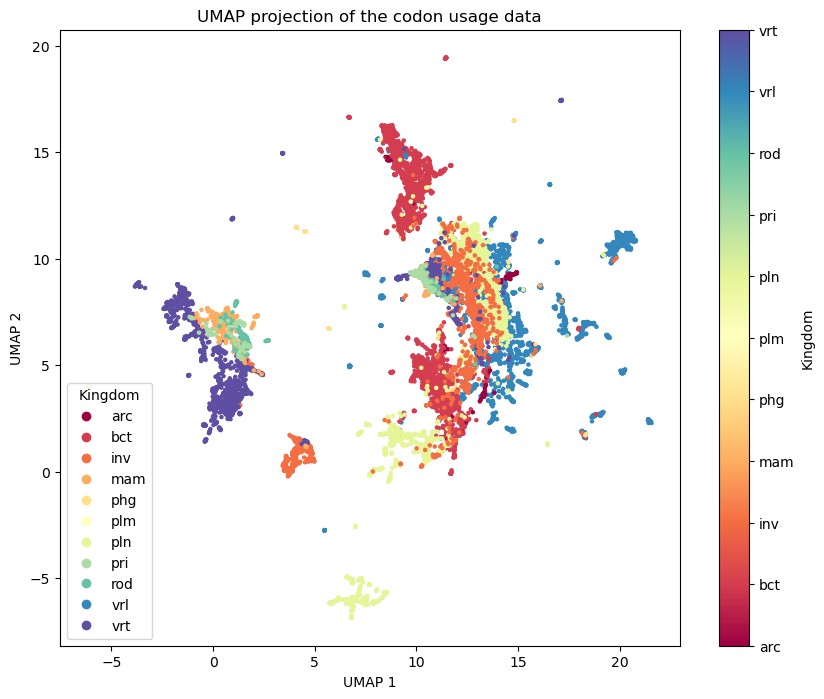

In [5]:

# Assuming 'df' is your dataframe

# Convert all features to numeric, coerce errors to NaN, and drop rows with NaN values
features = df.drop('Kingdom', axis=1)
features = features.apply(pd.to_numeric, errors='coerce')
features = features.dropna()

# Align labels with the filtered features
labels = df['Kingdom'].loc[features.index]

# Convert labels to a categorical type
labels = labels.astype('category')

# Fit and transform the data using UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(features)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels.cat.codes.to_numpy(),  # Convert categories to numeric codes
    cmap='Spectral',
    s=5
)

# Add colorbar with categories
colorbar = plt.colorbar(scatter, ticks=range(len(labels.cat.categories)))
colorbar.ax.set_yticklabels(labels.cat.categories)
colorbar.set_label('Kingdom')

plt.title('UMAP projection of the codon usage data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Create a legend
handles, _ = scatter.legend_elements()
plt.legend(handles, labels.cat.categories, title="Kingdom")

plt.show()


### Class Distributions 

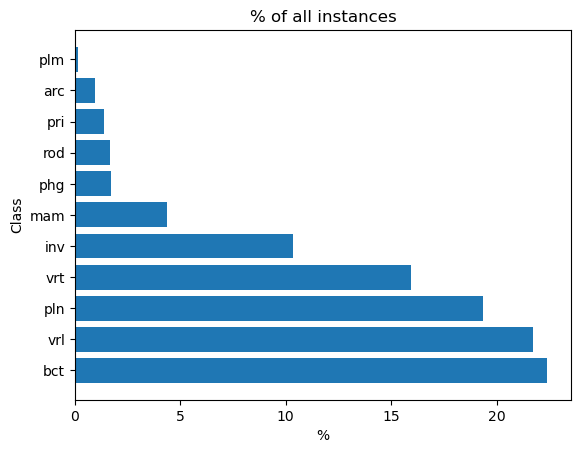

In [6]:
temp = df["Kingdom"].value_counts()/len(df["Kingdom"])*100
plt.barh(temp.index, temp.values)
plt.title('% of all instances')
plt.xlabel('%')
plt.ylabel('Class')
plt.show()

In [7]:
print(df["Kingdom"].value_counts())

Kingdom
bct    2919
vrl    2831
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: count, dtype: int64


In [8]:
X = df.drop(["Kingdom"], axis = 1).values
y = LabelEncoder().fit_transform(df['Kingdom'])

print(X.shape)
print(y.shape)

(13026, 64)
(13026,)


In [9]:
X_resampled, y_resampled = SMOTE(sampling_strategy= "not majority").fit_resample(X, y)

print(X_resampled.shape)
print(y_resampled.shape)

(32109, 64)
(32109,)


In [10]:
model = XGBClassifier(booster='gbtree', 
                      objective='binary:logistic', 
                      eval_metric='logloss',
                      random_state=42)

In [11]:
# N_test_ratio = 0.3  # Start with 30% test size
# max_iter = 5  # Max iterations to avoid infinite loops
# U_target = 0.0001
# current_iter = 0

# while current_iter < max_iter:
#     # Split data into training and test sets
#     train_data, test_data, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=N_test_ratio, random_state=42)

#     # Perform cross-validation on the training set to measure U_data
#     cv_scores = cross_val_score(model, train_data, train_labels, cv=4)
#     U_data = np.std(cv_scores)  # Uncertainty as standard deviation of validation scores

#     # Check for convergence
#     print(f"Iteration {current_iter + 1}: U_data={U_data:.4f}, N_test_ratio={N_test_ratio:.4f}")

#     # Adjust test set size
#     N_test_ratio *= (U_data / U_target) ** 2

#     current_iter += 1
#     print(N_test_ratio)
# # Final Training and Evaluation
# print("Final split ratio:", N_test_ratio)

In [ ]:
from skopt import BayesSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size= 0.3)

opt = BayesSearchCV(
    XGBClassifier(),
    {
    'max_depth': (3, 15),  # integer valued parameter
    'learning_rate': (1e-4, 0.3, 'log-uniform'),  # log-uniform: vary learning rate exponentially
    'n_estimators': (50, 1000),  # integer valued parameter
    'gamma': (1e-6, 5, 'log-uniform'),  # log-uniform: vary gamma exponentially
    'min_child_weight': (1, 10),  # integer valued parameter
    'subsample': (0.5, 1.0),  # uniform distribution
    'colsample_bytree': (0.5, 1.0),  # uniform distribution
    'reg_alpha': (1e-6, 10, 'log-uniform'),  # L1 regularization
    'reg_lambda': (1e-6, 10, 'log-uniform'),  # L2 regularization
    },
    n_iter=25,
    cv=3
)

start = time()
opt.fit(X_resampled, y_resampled)
print("time:", time() - start)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

time: 3337.5116968154907
val. score: 0.9762683359805662


NameError: name 'X_test' is not defined

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size= 0.3)


print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("Optimal parameters: %s" % opt.best_params_)

val. score: 0.9762683359805662
test score: 1.0
Optimal parameters: OrderedDict({'colsample_bytree': 0.5, 'gamma': 7.484627565770248e-06, 'learning_rate': 0.3, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 1e-06, 'reg_lambda': 10.0, 'subsample': 1.0})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size= 0.3)

In [20]:
best_params = {
    'colsample_bytree': 0.5,
    'gamma': 7.484627565770248e-06,
    'learning_rate': 0.3,
    'max_depth': 8,
    'min_child_weight': 1,
    'n_estimators': 1000,
    'reg_alpha': 1e-06,
    'reg_lambda': 10.0,
    'subsample': 1.0
}

# Create the XGBClassifier with the specified parameters
model = XGBClassifier(**best_params)

# Train the classifier on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7.484627565770248e-06, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [21]:
y_pred = model.predict(X_test)

In [22]:
cm = confusion_matrix(y_test, y_pred)

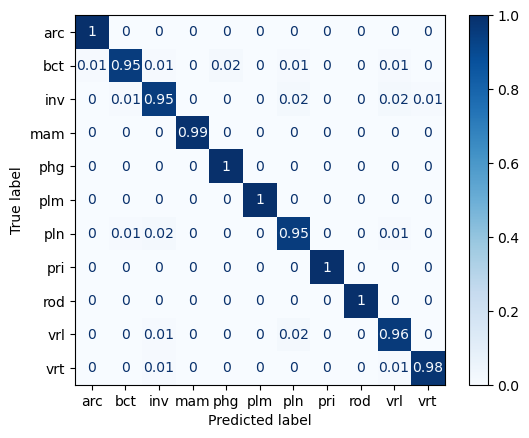

In [24]:
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.around(cm_normalized, decimals=2)

# Display the normalized and rounded confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()

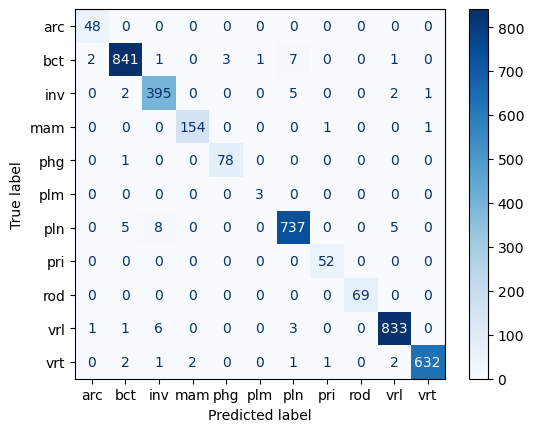

In [31]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()